In [1]:
import os
from glob import glob
import pandas as pd
import numpy as np
from pathlib import Path
from scipy import stats
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import gridspec
import json
import torch
import gpytorch
import h5py
import collections
import scipy
import torch
import subprocess
import sys

from bnn_priors import prior

from bnn_priors.exp_utils import load_samples

%matplotlib inline
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

In [2]:
plt.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [3]:

def flatten(in_dict):
    out_dict = {}
    for k, v in in_dict.items():
        if isinstance(v, dict):
            v_flat = flatten(v)
            out_dict.update({k+"."+v_k: v_v for v_k, v_v in v_flat.items()})
        else:
            out_dict[k] = v
    return out_dict

def collect_runs(base_log_dir, metrics_must_exist=True):
    base_log_dir = Path(base_log_dir)
    series_list = []
    
    for run in os.listdir(base_log_dir):
        if run in ["_sources", "jugdir"]:
            continue
            
        if metrics_must_exist and not os.path.exists(base_log_dir/run/"metrics.h5"):
            continue
            
        try:
            with open(base_log_dir/run/"run.json") as f:
                s2 = pd.Series(flatten(json.load(f)))
            with open(base_log_dir/run/"config.json") as f:
                s1 = pd.Series(flatten(json.load(f)))
        except FileNotFoundError:
            continue

        s2["the_dir"] = base_log_dir/run
        series_list.append(pd.concat([s1, s2]))
        
    return pd.DataFrame(series_list)


def unique_cols(df, blacklist=set([
     'heartbeat',
     'log_dir',
     'run_id',
     'host.cpu',
     'host.gpus.driver_version',
     'host.hostname',
     'host.python_version',
     'start_time',
     'status',
     'stop_time',
     'the_dir',
     'result.acc_last',
     'result.acc_mean',
     'result.acc_std',
     'result.acc_stderr',
     'result.lp_ensemble',
     'result.lp_ensemble_std',
     'result.lp_ensemble_stderr',
     'result.lp_last',
     'result.lp_mean',
     'result.lp_std',
     'result.lp_stderr'])):

    different_cols = []
    for col in df:
        if col in blacklist or col.startswith("meta.options") or col.startswith("result."):
            continue
        try:
            if len(df[col].unique()) > 1:
                different_cols.append(col)

        except TypeError:
            pass
    return different_cols

# SGD runs for various data sets

Run `eval_bnn.py` and construct the overall dataframe

In [4]:
df = collect_runs("../logs/0_31_googleresnet_cifar10_sgd")

In [5]:
good_runs = df[(df["n_epochs"] == 600) & (df["status"] == "COMPLETED")]

In [6]:
df.columns

Index(['lr', 'momentum', 'model', 'data', 'width', 'temperature',
       'weight_decay', 'sampling_decay', 'n_epochs', 'status', 'the_dir',
       'result.lp_ensemble', 'result.lp_last', 'result.acc_ensemble',
       'result.acc_last', 'result.ece', 'result.ace', 'result.rmsce'],
      dtype='object')

In [7]:
def eval_bnn(**config):
    args = [sys.executable, "eval_bnn.py", "with",
                               *[f"{k}={v}" for k, v in config.items()]]
    print(" ".join(args))
    complete = subprocess.run(args)
    if complete.returncode != 0:
        raise SystemError(f"Process returned with code {complete.returncode}")

#for i, (_, run) in enumerate(good_runs.iterrows()):
if False:
    print(f"run {i}/{len(good_runs)}")
    config_file = str(run["the_dir"]/"config.json")
    
    calibration_data = {
        "mnist": "rotated_mnist",
        "fashion_mnist": "fashion_mnist",
        "cifar10": "cifar10c-gaussian_blur",
        "cifar10_augmented": "cifar10c-gaussian_blur",
    }[run["data"]]
    
    eval_bnn(is_run_sgd=True, calibration_eval=True, eval_data=calibration_data,
             config_file=config_file, skip_first=2, batch_size=128)
    
    ood_data = {
        "mnist": "fashion_mnist",
        "fashion_mnist": "mnist",
        "cifar10": "svhn",
        "cifar10_augmented": "svhn",
    }[run["data"]]    
    
    eval_bnn(is_run_sgd=True, ood_eval=True, eval_data=ood_data,
             config_file=config_file, skip_first=2, batch_size=128)

In [8]:
runs_with_eval = []

for _, run in good_runs.iterrows():
    corresponding = collect_runs(run["the_dir"]/"eval", metrics_must_exist=False)
    
    new_run = [run]
    for _, corr in corresponding.iterrows():
        orig_keys = [k for k in corr.index if k.startswith("result.")]
        if corr["calibration_eval"]:
            purpose = "calibration"
            assert not corr["ood_eval"]
        elif corr["ood_eval"]:
            purpose = "ood"
        else:
            raise ValueError("unknown purpose")
        new_keys = [k.replace("result.", purpose+".") for k in orig_keys]
        for k in new_keys:
            assert k not in run.index

        new_corr = corr[orig_keys]
        new_corr.index = new_keys
        new_run.append(new_corr)
    runs_with_eval.append(pd.concat(new_run))
runs_with_eval = pd.DataFrame(runs_with_eval)

In [9]:
runs_with_eval.to_pickle("4.1_sgd_runs.pkl.gz")

In [10]:
df = runs_with_eval
df[(df["model"] == "classificationdensenet") & (df["data"] == "fashion_mnist")]["ood.auroc"].std()

0.023595474550117807

In [11]:
result_cols = [c for c in df.columns if c.startswith("result.")]

# df[[*unique_cols(df), *result_cols]]

In [12]:
selected_df = df[(df["model"] == "googleresnet") &
    (df["sampling_decay"] == "stairs") & (
    df["weight_decay"] == 0.0) & (df["data"] == "cifar10_augmented") & (df["n_epochs"] == 600)]

selected_df[unique_cols(selected_df)]

,calibration.acc_ensemble,calibration.acc_last,calibration.ace,calibration.ece,calibration.lp_ensemble,calibration.lp_last,calibration.rmsce,ood.acc_ensemble,ood.acc_last,ood.lp_ensemble,ood.lp_last,ood.auprc,ood.auroc
12,0.57992,0.57808,0.070301,0.339098,-3.698604,-5.166851,0.017816,0.111593,0.112208,-14.327375,-18.859972,0.812479,0.850937
19,0.60062,0.60092,0.066438,0.310371,-3.296371,-4.026644,0.016069,0.112093,0.111670,-13.750171,-18.311346,0.788291,0.857452
28,0.58688,0.59300,0.069103,0.328934,-3.722222,-4.910019,0.017433,0.109096,0.108789,-13.546185,-17.383140,0.822754,0.866951
31,0.62360,0.61988,0.062100,0.295627,-3.221409,-4.042280,0.015735,0.121351,0.120698,-14.441580,-17.357203,0.829252,0.872803
33,0.59562,0.59636,0.066751,0.317080,-3.818526,-4.744672,0.016639,0.128150,0.128380,-14.503687,-17.094838,0.802936,0.865113
37,0.62906,0.62604,0.061356,0.292350,-3.127157,-3.934229,0.015735,0.112861,0.112976,-12.441857,-15.471169,0.839574,0.872455
41,0.58856,0.58854,0.067116,0.319498,-3.133624,-4.129319,0.016887,0.110479,0.110633,-12.430272,-15.962485,0.825453,0.875109
45,0.59692,0.59304,0.067098,0.313685,-3.678192,-4.397396,0.016606,0.112784,0.113360,-12.673069,-15.458246,0.838132,0.878780
47,0.63326,0.62900,0.060622,0.284013,-2.971198,-3.680176,0.014833,0.112477,0.111862,-10.273316,-13.039008,0.854017,0.892781
57,0.59296,0.59576,0.067770,0.317320,-4.211191,-4.721933,0.016419,0.115781,0.117893,-16.807369,-19.767828,0.847471,0.887134


In [13]:
df[(df["lr"] == 0.1) & (df["sampling_decay"] == "stairs2") & (
    df["weight_decay"] == 0.002) ][result_cols].mean()

result.lp_ensemble    NaN
result.lp_last        NaN
result.acc_ensemble   NaN
result.acc_last       NaN
result.ece            NaN
result.ace            NaN
result.rmsce          NaN
dtype: float64

In [14]:
df[(df["data"] == "mnist") & (df["model"] == "classificationdensenet")][result_cols].mean()

result.lp_ensemble    -0.139037
result.lp_last        -0.139228
result.acc_ensemble    0.980150
result.acc_last        0.980150
result.ece             0.015937
result.ace             0.002136
result.rmsce           0.005417
dtype: float64

In [15]:
df[(df["data"] == "mnist") & (df["model"] == "classificationconvnet")][result_cols].mean()

result.lp_ensemble    -0.056233
result.lp_last        -0.056345
result.acc_ensemble    0.990860
result.acc_last        0.990850
result.ece             0.007469
result.ace             0.000750
result.rmsce           0.003355
dtype: float64

In [16]:
1 - df[(df["data"] == "cifar10") & (df["model"] == "googleresnet")][result_cols].mean()

result.lp_ensemble     2.249626
result.lp_last         2.267479
result.acc_ensemble    0.163700
result.acc_last        0.163770
result.ece             0.869031
result.ace             0.974145
result.rmsce           0.980767
dtype: float64

In [17]:
df[(df["data"] == 0.1) & (df["sampling_decay"] == "stairs2") & (
    df["weight_decay"] == 0) ][result_cols].mean()

result.lp_ensemble    NaN
result.lp_last        NaN
result.acc_ensemble   NaN
result.acc_last       NaN
result.ece            NaN
result.ace            NaN
result.rmsce          NaN
dtype: float64

# Get the lengthscales and df's from each layer

In [18]:
import pickle

def collect_weights(df):
    samples = collections.defaultdict( lambda: [], {})
    for _, row in df.iterrows():
        try:
            s = load_samples(row["the_dir"]/"samples.pt", idx=-1, keep_steps=False)
        except pickle.UnpicklingError:
            continue
        assert len(samples.keys()) == 0 or set(s.keys()) == set(samples.keys())
        for k in s.keys():
            samples[k].append(s[k])
    return {k: torch.stack(v, dim=0) for k, v in samples.items()}

In [19]:
samples = collect_weights(good_runs[good_runs["data"] == "cifar10_augmented"])

In [20]:
samples['net.module.0.weight_prior.p'].shape

torch.Size([10, 16, 3, 3, 3])

In [21]:
for k in samples.keys():
    if k.endswith(".p"):
        print(k, tuple(samples[k].shape))

net.module.0.weight_prior.p (10, 16, 3, 3, 3)
net.module.10.main.0.weight_prior.p (10, 64, 64, 3, 3)
net.module.10.main.3.weight_prior.p (10, 64, 64, 3, 3)
net.module.11.main.0.weight_prior.p (10, 64, 64, 3, 3)
net.module.11.main.3.weight_prior.p (10, 64, 64, 3, 3)
net.module.14.bias_prior.p (10, 10)
net.module.14.weight_prior.p (10, 10, 64)
net.module.3.main.0.weight_prior.p (10, 16, 16, 3, 3)
net.module.3.main.3.weight_prior.p (10, 16, 16, 3, 3)
net.module.4.main.0.weight_prior.p (10, 16, 16, 3, 3)
net.module.4.main.3.weight_prior.p (10, 16, 16, 3, 3)
net.module.5.main.0.weight_prior.p (10, 16, 16, 3, 3)
net.module.5.main.3.weight_prior.p (10, 16, 16, 3, 3)
net.module.6.main.0.weight_prior.p (10, 32, 16, 3, 3)
net.module.6.main.3.weight_prior.p (10, 32, 32, 3, 3)
net.module.6.shortcut.0.weight_prior.p (10, 32, 16, 1, 1)
net.module.7.main.0.weight_prior.p (10, 32, 32, 3, 3)
net.module.7.main.3.weight_prior.p (10, 32, 32, 3, 3)
net.module.8.main.0.weight_prior.p (10, 32, 32, 3, 3)
net.

In [22]:
conv_keys = ["net.module.0.weight_prior.p", *filter(
    lambda k: k.endswith(".p") and "main" in k, samples.keys())]
conv_keys.sort(key=lambda k: (int(k.split('.')[2]), k))

In [23]:
covs = {}
lens = {}
for k in conv_keys:
    M = samples[k].view(-1, 3*3)
    covs[k] = (M.t() @ M)
    lens[k] = len(M)

In [24]:
points = torch.from_numpy(np.mgrid[:3, :3].reshape(2, -1).T).contiguous().to(torch.float64)


In [25]:
import gpytorch
import math
torch.set_default_dtype(torch.float64)
kern = gpytorch.kernels.RBFKernel(batch_shape=torch.Size([1000]))
kern.lengthscale = torch.linspace(0.001**.5, 30**.5, 1000).unsqueeze(-1).pow(2)

In [26]:
S_inverse = kern(points).inv_matmul(torch.eye(9))
S_logdet = kern(points).logdet()

In [27]:
log_liks = {}
opt_lengthscale = {}
for k in covs.keys():
    with torch.no_grad():
        log_liks[k] = S_logdet.mul(lens[k] / -2) - 0.5 * S_inverse.mul(covs[k]).sum((-2, -1))
        opt_lengthscale[k] = kern.lengthscale[torch.argmax(log_liks[k])].item()

(-10000.0, 0.0)

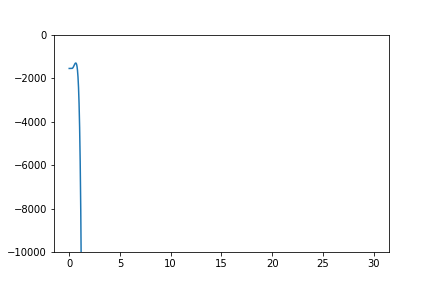

In [28]:
k = next(iter(log_liks.keys()))

plt.plot(kern.lengthscale.squeeze(-1).detach(), log_liks[k])
plt.ylim((-10000, 0))

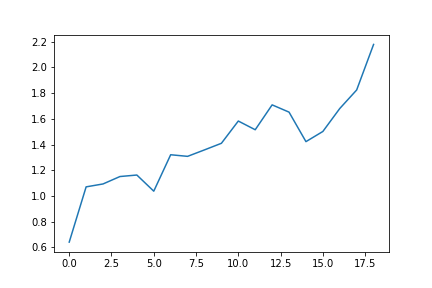

In [29]:
plt.plot(np.arange(len(conv_keys)), [opt_lengthscale[k] for k in conv_keys])

In [30]:
# check that log-likelihoods aren't buggy
dist = gpytorch.distributions.MultivariateNormal(torch.zeros(9), kern[100](points))
dist.log_prob(samples[k].view(-1, 9)).sum(), log_liks[k][100] - math.log(2*math.pi) * 9 * lens[k]/2

(tensor(-5513.4573, grad_fn=<SumBackward0>), tensor(-5513.4573))

# Get max df of multivariate-T

In [31]:
class MVTFitter(torch.nn.Module):
    def __init__(self, p, df, permute=None, event_dim=2):
        flat_p = p.view(-1, 9)
        cov = (flat_p.t() @ flat_p) / len(flat_p)
        
        super().__init__()
        self.dist = prior.MultivariateT(
            p.size(), torch.zeros(9), cov.cholesky().detach().to(torch.get_default_dtype()),
            df=torch.nn.Parameter(torch.tensor(df, requires_grad=True)),
            event_dim=event_dim, permute=permute)
        
        self.dist.p.requires_grad_(False)
        self.dist.p[...] = p
        
    def closure(self):
        self.zero_grad()
        lp = -self.dist.log_prob()
        lp.backward()
        return lp

In [32]:
opt_dfs = {}

try_df_inits = torch.linspace(math.log(2.1), math.log(1000), 300).exp()

for key in conv_keys:
    max_lik = -np.inf
    
    for permute, event_dim in [(None, 2), (None, 3), (None, 4), ((0, 2, 1, 3, 4), 3)]:
        mvt = MVTFitter(samples[key], 3., permute=permute, event_dim=event_dim).cuda()
        for df_init in try_df_inits:
            with torch.no_grad():
                mvt.dist.df[...] = df_init

            lik = mvt.dist.log_prob().item()
            df = mvt.dist.df.item()
            if np.isnan(lik) or np.isnan(df):
                print("key", key, "saw a nan with lik", lik)

            if lik > max_lik:
                opt_dfs[key] = (lik, df, (permute, event_dim))
                max_lik = lik

In [33]:
opt_dfs

{'net.module.0.weight_prior.p': (-4112.993846305028,
  6.011245966063856,
  (None, 3)),
 'net.module.3.main.0.weight_prior.p': (-3222.278865661859,
  5.097041764391427,
  (None, 2)),
 'net.module.3.main.3.weight_prior.p': (-3408.6396281560174,
  6.9447244207846515,
  (None, 2)),
 'net.module.4.main.0.weight_prior.p': (-2008.4077003764319,
  6.802980537736434,
  (None, 2)),
 'net.module.4.main.3.weight_prior.p': (-666.6245776566849,
  8.535184234833107,
  (None, 2)),
 'net.module.5.main.0.weight_prior.p': (-4561.387973894467,
  5.768367509654538,
  (None, 2)),
 'net.module.5.main.3.weight_prior.p': (2428.525077553126,
  15.844792250684804,
  (None, 3)),
 'net.module.6.main.0.weight_prior.p': (5952.406233850634,
  6.264350876402998,
  (None, 2)),
 'net.module.6.main.3.weight_prior.p': (14278.932825181124,
  16.51194091580221,
  (None, 2)),
 'net.module.7.main.0.weight_prior.p': (14380.752107462999,
  33.982139380106915,
  ((0, 2, 1, 3, 4), 3)),
 'net.module.7.main.3.weight_prior.p': (319

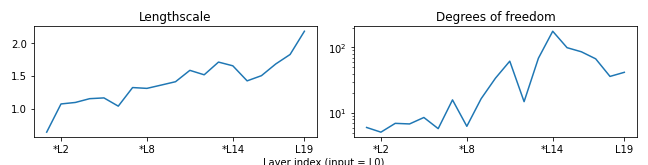

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(9, 2.3), sharex=True)

ax = axes[1]
ax.set_title("Degrees of freedom")
ax.plot([opt_dfs[k][1] for k in conv_keys])
ax.set_xticks([1, 7, 13, 18])
ax.set_xticklabels(["*L2", "*L8", "*L14", "L19"])
ax.set_yscale('log')

ax = axes[0] 
ax.set_title("Lengthscale")
ax.plot([opt_lengthscale[k] for k in conv_keys])

fig.text(0.5, 0, 'Layer index (input = L0)', ha='center')
#fig.suptitle("ResNet-20, CIFAR-10 SGD: fitted parameters for T-distribution and Gaussian")
fig.tight_layout()
fig.savefig("../figures/210122_resnet_fitted.pdf", bbox_inches="tight")

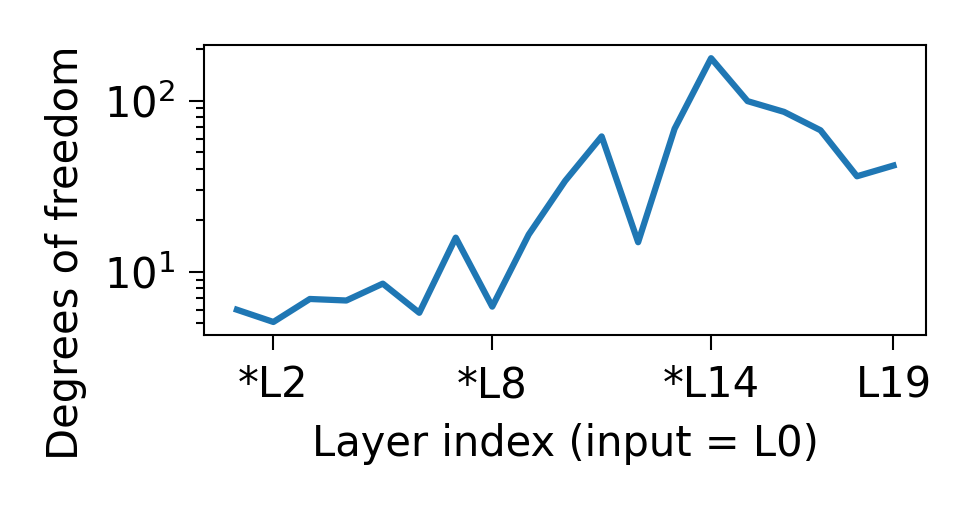

In [42]:
plt.rcParams.update({
    "axes.linewidth": 0.5,
    'ytick.major.width': 0.5,
    'xtick.major.width': 0.5,
    'ytick.minor.width': 0.5,
    'xtick.minor.width': 0.5,
    "figure.dpi": 300,
})
fig_width_pt = 234.8775
inches_per_pt = 1.0/72.27               # Convert pt to inches
fig_width = fig_width_pt*inches_per_pt  # width in inches

fig, axes = plt.subplots(1, 1, figsize=(fig_width, 1.7), sharex=True)

ax = axes
ax.set_ylabel("Degrees of freedom", horizontalalignment="right", position=(0, 1))
ax.plot([opt_dfs[k][1] for k in conv_keys])
ax.set_xticks([1, 7, 13, 18])
ax.set_xticklabels(["*L2", "*L8", "*L14", "L19"])
ax.set_yscale('log')
ax.set_xlabel('Layer index (input = L0)')

fig.tight_layout()
fig.savefig("../figures/210126-resnet-dof.pdf")

# Plot covariance matrices of every layer

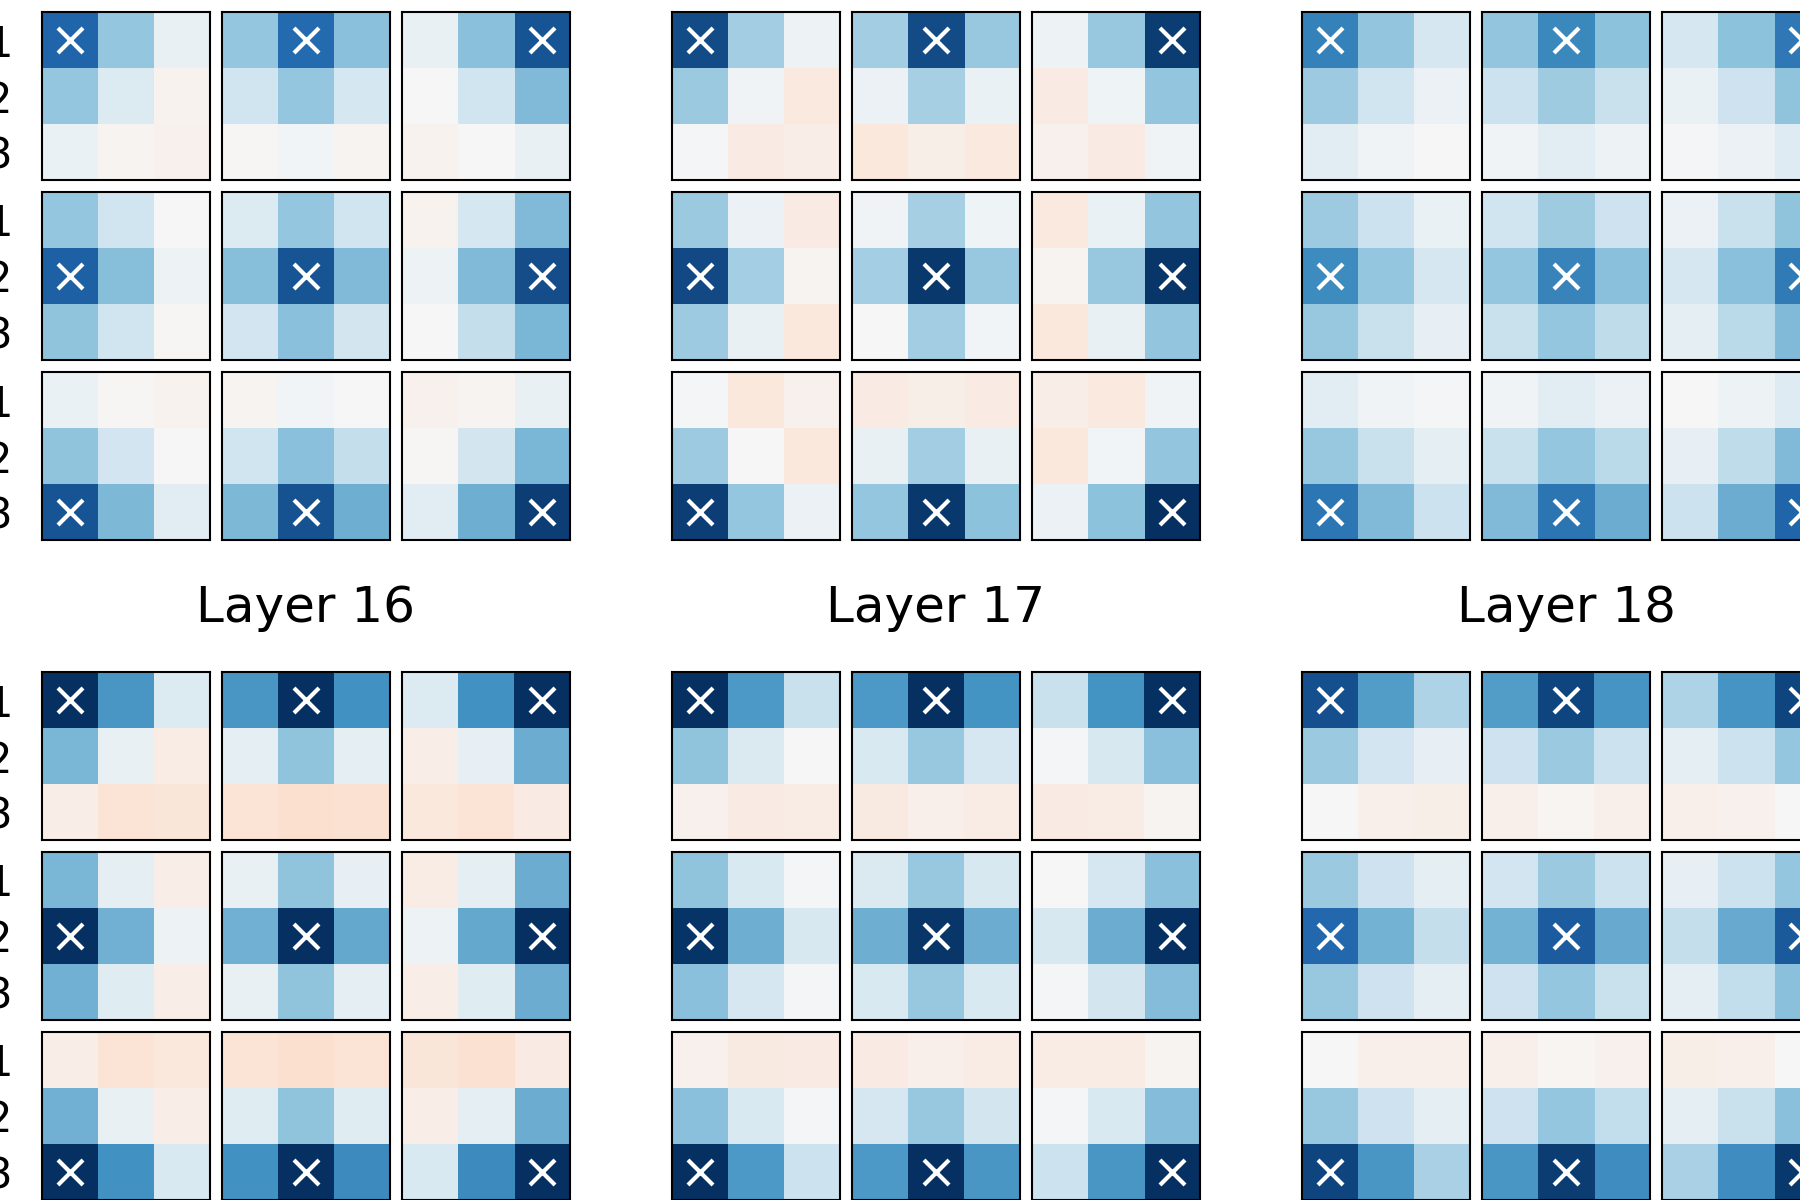

In [40]:
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "sans-serif"})

fig = plt.figure()

mean_covs = {k: covs[k]/lens[k] * samples[k].size(-3) for k in conv_keys}

plots_x = 5
plots_y = 4

wsep = -0.04
hsep = 0.01
w_cov_sep = 0.05
h_cov_sep = 0.1
width = height = (1 - w_cov_sep*(plots_x-1) - wsep*3*plots_x)/plots_x / 2
ttl_marg=12


extreme = max(*(mean_covs[key].abs().max().item() for k in mean_covs.keys()))  #1.68
assert extreme < 1.7
extreme = 1.7
norm = Normalize(-extreme, extreme)
    
def plot_at(key, base_bottom, base_left, is_bottom_row=False, is_left_col=False, title="title"):
    max_bottom = base_bottom
    max_left = base_left
    
    for y in range(3):
        for x in range(3):
            bottom = base_bottom + (height+hsep) * (2-y)
            left = base_left + (width+wsep) * x
            max_bottom = max(max_bottom, bottom+height+hsep)
            max_left = max(max_left, left+width+wsep)
            
            if x == 0 and is_left_col:
                yticks = [1, 2, 3]
            else:
                yticks = []

            if (y == 2 and is_bottom_row) or title=="Layer 15":
                xticks = [1, 2, 3]
            else:
                xticks = []
            ax = fig.add_axes([left, bottom, width, height], xticks=xticks, yticks=yticks)
                              #title=f"cov. w/ ({x + 1}, {y +1})")
            mappable = ax.imshow(
                mean_covs[key][y*3+x, :].reshape((3, 3)),
                cmap=plt.get_cmap('RdBu'),
                extent=[0.5, 3.5, 3.5, 0.5], norm=norm)
            ax.plot([x+1], [y+1], marker='x', ls='none', color=('black' if title == "Layer 19" else 'white'))
            ax.tick_params(left=False, bottom=False)  # remove ticks

            if y==0 and x==1:
                ttl = ax.set_title(title, pad=ttl_marg)
    return max_bottom, max_left, mappable

# Iterate over the indices for axes, starting from the bottom-left of the plots
cur_bottom = 0
for y_idx in reversed(range(0, plots_y)):
    cur_left = 0
    for x_idx in range(min(len(conv_keys)-y_idx*plots_x, plots_x)):
        key = conv_keys[y_idx*plots_x + x_idx]
        if key in ['net.module.3.main.0.weight_prior.p',
                   'net.module.6.main.0.weight_prior.p',
                   'net.module.9.main.0.weight_prior.p',]:
            marker = "*"
        else:
            marker = ""
        
        
        next_bottom, cur_left, mappable = plot_at(
            key, cur_bottom, cur_left,
            is_bottom_row=(y_idx == plots_y-1),
            is_left_col=(x_idx == 0),
            title=f"{marker}Layer {conv_keys.index(key) + 1}")
        cur_left += w_cov_sep
        
    if cur_bottom == 0:
        cbar_ax = fig.add_axes([cur_left+0.03, cur_bottom, width/3, next_bottom-cur_bottom])
        fig.colorbar(mappable, cax=cbar_ax, ticks=[-extreme, -1, 0, 1, extreme])
    cur_bottom = next_bottom + h_cov_sep
    
fig.savefig("../figures/210122_googleresnet_covariances_all.pdf", bbox_inches='tight')

In [37]:
cur_left, cur_bottom, extreme

(1.7499999999999996, 2.1999999999999997, 1.7)

In [38]:
conv_keys

['net.module.0.weight_prior.p',
 'net.module.3.main.0.weight_prior.p',
 'net.module.3.main.3.weight_prior.p',
 'net.module.4.main.0.weight_prior.p',
 'net.module.4.main.3.weight_prior.p',
 'net.module.5.main.0.weight_prior.p',
 'net.module.5.main.3.weight_prior.p',
 'net.module.6.main.0.weight_prior.p',
 'net.module.6.main.3.weight_prior.p',
 'net.module.7.main.0.weight_prior.p',
 'net.module.7.main.3.weight_prior.p',
 'net.module.8.main.0.weight_prior.p',
 'net.module.8.main.3.weight_prior.p',
 'net.module.9.main.0.weight_prior.p',
 'net.module.9.main.3.weight_prior.p',
 'net.module.10.main.0.weight_prior.p',
 'net.module.10.main.3.weight_prior.p',
 'net.module.11.main.0.weight_prior.p',
 'net.module.11.main.3.weight_prior.p']